# 1 MINUTE LTC-XRP DATA

## MODEL 1: ALL FEATURES

In [1]:
%reset -f

In [2]:
# imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [3]:
# read data

march_df = pd.read_csv("LTC_1min_XRP_1min_march.csv")
april_df = pd.read_csv("LTC_1min_XRP_1min_april.csv")

In [4]:
# combine data

df = pd.concat([march_df, april_df], axis=0)


# impute data

df['LTC Polarity'] = df['LTC Polarity'].fillna(value=df['LTC Polarity'].mean())
df['LTC Subjectivity'] = df['LTC Subjectivity'].fillna(value=df['LTC Subjectivity'].mean())
df['XRP Polarity'] = df['XRP Polarity'].fillna(value=df['XRP Polarity'].mean())
df['XRP Subjectivity'] = df['XRP Subjectivity'].fillna(value=df['XRP Subjectivity'].mean())
df['Net Polarity'] = df['Net Polarity'].fillna(value=df['Net Polarity'].mean())
df['Net Subjectivity'] = df['Net Subjectivity'].fillna(value=df['Net Subjectivity'].mean())

# split testing and training data

train_size = int(np.round(df.shape[0]*0.90))
test_size = int(np.round(df.shape[0]*0.10))

training_set = df.iloc[:train_size, 1:]
test_set = df.iloc[test_size:, 1:]

In [5]:
training_set.head()

,LTC Polarity,LTC Subjectivity,LTC Price,LTC Volume USD,XRP Polarity,XRP Subjectivity,XRP Price,XRP Volume USD,Net Polarity,Net Subjectivity,Net Volume,Price Ratio
0,0.142857,0.278571,166.03,4073.107475,0.104545,0.036364,0.41742,20231.418290,0.038312,0.242208,-16158.310815,0.002514
1,0.000000,0.200000,166.27,58.504682,0.175000,0.150000,0.41742,0.000000,-0.175000,0.050000,58.504682,0.002510
2,0.000000,0.000000,165.25,147.778501,0.045614,0.244887,0.41469,67316.417510,-0.045614,-0.244887,-67168.639009,0.002509
3,0.094549,0.259995,164.95,379.522146,-0.035530,0.207702,0.41491,42829.337870,0.017775,0.003248,-42449.815724,0.002515
4,0.000000,0.000000,164.74,81015.336680,0.092222,0.235926,0.41452,9084.238362,-0.092222,-0.235926,71931.098318,0.002516


In [6]:
test_set.head()

,LTC Polarity,LTC Subjectivity,LTC Price,LTC Volume USD,XRP Polarity,XRP Subjectivity,XRP Price,XRP Volume USD,Net Polarity,Net Subjectivity,Net Volume,Price Ratio
8496,0.094549,0.259995,180.52,0.000000,0.053333,0.305833,0.46038,0.000000,0.017775,0.003248,0.00000,0.002550
8497,0.094549,0.259995,180.42,9167.670635,-0.081149,0.207313,0.45998,615.768545,0.017775,0.003248,8551.90209,0.002549
8498,0.094549,0.259995,180.43,2870.100010,0.031491,0.167652,0.46037,51712.460850,0.017775,0.003248,-48842.36084,0.002552
8499,0.094549,0.259995,180.43,4505.337100,0.090476,0.142857,0.46049,2762.940000,0.017775,0.003248,1742.39710,0.002552
8500,0.000000,1.000000,180.43,0.000000,0.084764,0.280093,0.46061,5330.178920,-0.084764,0.719907,-5330.17892,0.002553


In [7]:
# feature scaling

x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))

training_set.iloc[:, 0:11] = x_sc.fit_transform(training_set.iloc[:, 0:11])
training_set['Price Ratio'] = y_sc.fit_transform(training_set['Price Ratio'].values.reshape(-1,1))
training_set_scaled = training_set.values

In [8]:
# creating a data structure with 6 time-steps and 1 output

window = 15

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i, 0:11])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 11))

In [9]:
X_train.shape

(76448, 15, 11)

In [10]:
y_train.shape

(76448,)

In [11]:
# model

model_1 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 50, return_sequences = True))
model_1.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 50, return_sequences = True))
model_1.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 50))
model_1.add(Dropout(0.2))

# Adding the output layer
model_1.add(Dense(units = 1))

# Compiling the RNN
model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [12]:
# Fitting the RNN to the Training set

history_1 = model_1.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
2389/2389 [==============================] - 51s 19ms/step - loss: 0.0017
Epoch 2/20
2389/2389 [==============================] - 46s 19ms/step - loss: 6.7639e-04
Epoch 3/20
2389/2389 [==============================] - 46s 19ms/step - loss: 6.0055e-04
Epoch 4/20
2389/2389 [==============================] - 45s 19ms/step - loss: 5.6875e-04
Epoch 5/20
2389/2389 [==============================] - 46s 19ms/step - loss: 5.3126e-04
Epoch 6/20
2389/2389 [==============================] - 46s 19ms/step - loss: 5.3361e-04
Epoch 7/20
2389/2389 [==============================] - 46s 19ms/step - loss: 5.1424e-04
Epoch 8/20
2389/2389 [==============================] - 49s 20ms/step - loss: 5.0789e-04
Epoch 9/20
2389/2389 [==============================] - 46s 19ms/step - loss: 5.0021e-04
Epoch 10/20
2389/2389 [==============================] - 46s 19ms/step - loss: 4.9539e-04
Epoch 11/20
2389/2389 [==============================] - 46s 19ms/step - loss: 4.9532e-04
Epoch 12/20
2389/2389 [

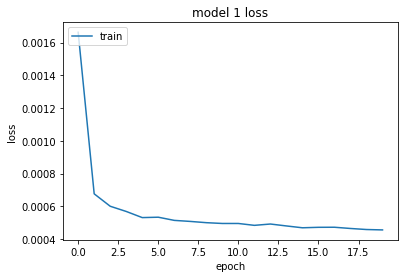

In [13]:
plt.plot(history_1.history['loss'])
#plt.plot(history_1.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
# prep inputs to get predictions

dataset_train = df.iloc[:train_size, 1:]
dataset_test = df.iloc[train_size:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

dataset_total.iloc[:, 0:11] = x_sc.fit_transform(dataset_total.iloc[:, 0:11])
dataset_total['Price Ratio'] = y_sc.fit_transform(dataset_total['Price Ratio'].values.reshape(-1,1))

inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,12)

X_test = []
for i in range(window, test_size+window):
    X_test.append(inputs[i-window:i, 0:11])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 11))

# get predictions

predicted_values = model_1.predict(X_test)
predicted_values = y_sc.inverse_transform(predicted_values)

C:\Users\Felix\AppData\Local\Temp\ipykernel_19244\2665450548.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


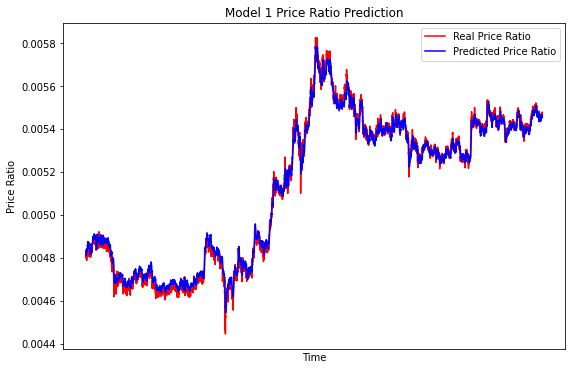

In [15]:
# visualising the results

plt.figure(figsize=(9, 6))
plt.plot(df.iloc[train_size:, 0], dataset_test['Price Ratio'].values, color = 'red', label = 'Real Price Ratio')
plt.plot(df.iloc[train_size:, 0], predicted_values, color = 'blue', label = 'Predicted Price Ratio')
plt.xticks(np.arange(0,test_size,50))
plt.title('Model 1 Price Ratio Prediction')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Price Ratio')
plt.legend()
plt.savefig("ltc_xrp_1min_model1")
plt.show()

In [16]:
# rmse

rmse = mean_squared_error(dataset_test['Price Ratio'].values, predicted_values, squared=False)
print(rmse)

2.5332132984967985e-05


In [17]:
# std

test_std = np.std(dataset_test['Price Ratio'].values)
print(test_std)

0.0003454332568758069


## MODEL 2: ONLY SENTIMENT DATA

In [18]:
%reset -f

In [19]:
# imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [20]:
# read data

march_df = pd.read_csv("LTC_1min_XRP_1min_march.csv")
april_df = pd.read_csv("LTC_1min_XRP_1min_april.csv")

In [21]:
# combine data

df = pd.concat([march_df, april_df], axis=0)

# impute data

df['LTC Polarity'] = df['LTC Polarity'].fillna(value=df['LTC Polarity'].mean())
df['LTC Subjectivity'] = df['LTC Subjectivity'].fillna(value=df['LTC Subjectivity'].mean())
df['XRP Polarity'] = df['XRP Polarity'].fillna(value=df['XRP Polarity'].mean())
df['XRP Subjectivity'] = df['XRP Subjectivity'].fillna(value=df['XRP Subjectivity'].mean())
df['Net Polarity'] = df['Net Polarity'].fillna(value=df['Net Polarity'].mean())
df['Net Subjectivity'] = df['Net Subjectivity'].fillna(value=df['Net Subjectivity'].mean())

df = df[["Timestamp", "LTC Polarity", "XRP Polarity", "LTC Subjectivity", "XRP Subjectivity", "Net Polarity", "Net Subjectivity", "Price Ratio"]]

# split testing and training data

train_size = int(np.round(df.shape[0]*0.90))
test_size = int(np.round(df.shape[0]*0.10))

training_set = df.iloc[:train_size, 1:]
test_set = df.iloc[test_size:, 1:]

In [22]:
training_set.head()

,LTC Polarity,XRP Polarity,LTC Subjectivity,XRP Subjectivity,Net Polarity,Net Subjectivity,Price Ratio
0,0.142857,0.104545,0.278571,0.036364,0.038312,0.242208,0.002514
1,0.000000,0.175000,0.200000,0.150000,-0.175000,0.050000,0.002510
2,0.000000,0.045614,0.000000,0.244887,-0.045614,-0.244887,0.002509
3,0.094549,-0.035530,0.259995,0.207702,0.017775,0.003248,0.002515
4,0.000000,0.092222,0.000000,0.235926,-0.092222,-0.235926,0.002516


In [23]:
test_set.head()

,LTC Polarity,XRP Polarity,LTC Subjectivity,XRP Subjectivity,Net Polarity,Net Subjectivity,Price Ratio
8496,0.094549,0.053333,0.259995,0.305833,0.017775,0.003248,0.002550
8497,0.094549,-0.081149,0.259995,0.207313,0.017775,0.003248,0.002549
8498,0.094549,0.031491,0.259995,0.167652,0.017775,0.003248,0.002552
8499,0.094549,0.090476,0.259995,0.142857,0.017775,0.003248,0.002552
8500,0.000000,0.084764,1.000000,0.280093,-0.084764,0.719907,0.002553


In [24]:
# feature scaling

x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))

training_set.iloc[:, 0:6] = x_sc.fit_transform(training_set.iloc[:, 0:6])
training_set['Price Ratio'] = y_sc.fit_transform(training_set['Price Ratio'].values.reshape(-1,1))
training_set_scaled = training_set.values

In [25]:
# creating a data structure with 6 time-steps and 1 output

window = 15

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i, 0:6])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))

In [26]:
X_train.shape

(76448, 15, 6)

In [27]:
y_train.shape

(76448,)

In [28]:
# model

model_2 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50, return_sequences = True))
model_2.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50, return_sequences = True))
model_2.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50))
model_2.add(Dropout(0.2))

# Adding the output layer
model_2.add(Dense(units = 1))

# Compiling the RNN
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [29]:
# Fitting the RNN to the Training set

history_2 = model_2.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
2389/2389 [==============================] - 51s 19ms/step - loss: 0.0626
Epoch 2/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0426
Epoch 3/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0405
Epoch 4/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0400
Epoch 5/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0396
Epoch 6/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0393
Epoch 7/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0392
Epoch 8/20
2389/2389 [==============================] - 50s 21ms/step - loss: 0.0386
Epoch 9/20
2389/2389 [==============================] - 48s 20ms/step - loss: 0.0384
Epoch 10/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0380
Epoch 11/20
2389/2389 [==============================] - 47s 20ms/step - loss: 0.0376
Epoch 12/20
2389/2389 [==============================] - 48s 20

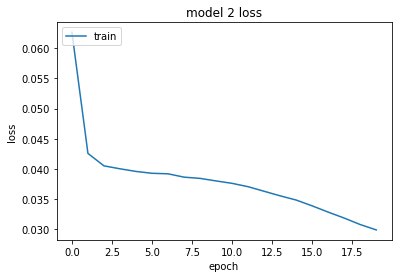

In [30]:
plt.plot(history_2.history['loss'])
#plt.plot(history_2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
# prep inputs to get predictions

dataset_train = df.iloc[:train_size, 1:]
dataset_test = df.iloc[train_size:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

dataset_total.iloc[:, 0:6] = x_sc.fit_transform(dataset_total.iloc[:, 0:6])
dataset_total['Price Ratio'] = y_sc.fit_transform(dataset_total['Price Ratio'].values.reshape(-1,1))

inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,7)

X_test = []
for i in range(window, test_size+window):
    X_test.append(inputs[i-window:i, 0:6])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

# get predictions

predicted_values = model_2.predict(X_test)
predicted_values = y_sc.inverse_transform(predicted_values)

C:\Users\Felix\AppData\Local\Temp\ipykernel_19244\3800209226.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


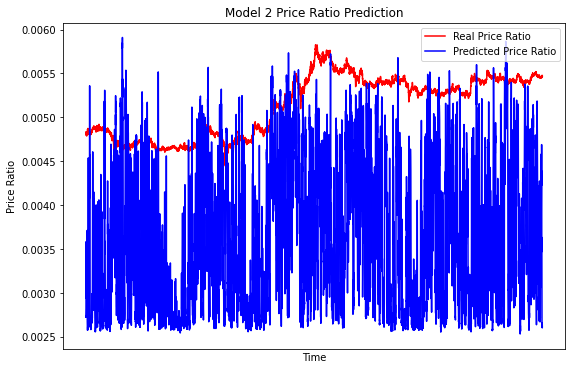

In [32]:
# visualising the results

plt.figure(figsize=(9, 6))
plt.plot(df.iloc[train_size:, 0], dataset_test['Price Ratio'].values, color = 'red', label = 'Real Price Ratio')
plt.plot(df.iloc[train_size:, 0], predicted_values, color = 'blue', label = 'Predicted Price Ratio')
plt.xticks(np.arange(0,test_size,50))
plt.title('Model 2 Price Ratio Prediction')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Price Ratio')
plt.legend()
plt.savefig("ltc_xrp_1min_model2")
plt.show()

In [33]:
# rmse

rmse = mean_squared_error(dataset_test['Price Ratio'].values, predicted_values, squared=False)
print(rmse)

0.0017499690849035578


In [34]:
# std

test_std = np.std(dataset_test['Price Ratio'].values)
print(test_std)

0.0003454332568758069


## MODEL 3: ONLY FINANCIAL DATA

In [35]:
%reset -f

In [36]:
# imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [37]:
# read data

march_df = pd.read_csv("LTC_1min_XRP_1min_march.csv")
april_df = pd.read_csv("LTC_1min_XRP_1min_april.csv")

In [38]:
# combine data

df = pd.concat([march_df, april_df], axis=0)

# impute data

df['LTC Polarity'] = df['LTC Polarity'].fillna(value=df['LTC Polarity'].mean())
df['LTC Subjectivity'] = df['LTC Subjectivity'].fillna(value=df['LTC Subjectivity'].mean())
df['XRP Polarity'] = df['XRP Polarity'].fillna(value=df['XRP Polarity'].mean())
df['XRP Subjectivity'] = df['XRP Subjectivity'].fillna(value=df['XRP Subjectivity'].mean())
df['Net Polarity'] = df['Net Polarity'].fillna(value=df['Net Polarity'].mean())
df['Net Subjectivity'] = df['Net Subjectivity'].fillna(value=df['Net Subjectivity'].mean())

df = df[["Timestamp", "LTC Price", "XRP Price", "LTC Volume USD", "XRP Volume USD", "Net Volume", "Price Ratio"]]

# split testing and training data

train_size = int(np.round(df.shape[0]*0.90))
test_size = int(np.round(df.shape[0]*0.10))

training_set = df.iloc[:train_size, 1:]
test_set = df.iloc[test_size:, 1:]

In [39]:
training_set.head()

,LTC Price,XRP Price,LTC Volume USD,XRP Volume USD,Net Volume,Price Ratio
0,166.03,0.41742,4073.107475,20231.418290,-16158.310815,0.002514
1,166.27,0.41742,58.504682,0.000000,58.504682,0.002510
2,165.25,0.41469,147.778501,67316.417510,-67168.639009,0.002509
3,164.95,0.41491,379.522146,42829.337870,-42449.815724,0.002515
4,164.74,0.41452,81015.336680,9084.238362,71931.098318,0.002516


In [40]:
test_set.head()

,LTC Price,XRP Price,LTC Volume USD,XRP Volume USD,Net Volume,Price Ratio
8496,180.52,0.46038,0.000000,0.000000,0.00000,0.002550
8497,180.42,0.45998,9167.670635,615.768545,8551.90209,0.002549
8498,180.43,0.46037,2870.100010,51712.460850,-48842.36084,0.002552
8499,180.43,0.46049,4505.337100,2762.940000,1742.39710,0.002552
8500,180.43,0.46061,0.000000,5330.178920,-5330.17892,0.002553


In [41]:
# feature scaling

x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))

training_set.iloc[:, 0:5] = x_sc.fit_transform(training_set.iloc[:, 0:5])
training_set['Price Ratio'] = y_sc.fit_transform(training_set['Price Ratio'].values.reshape(-1,1))
training_set_scaled = training_set.values

In [42]:
# creating a data structure with 6 time-steps and 1 output

window = 15

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i, 0:5])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [43]:
X_train.shape

(76448, 15, 5)

In [44]:
y_train.shape

(76448,)

In [45]:
# model

model_3 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_3.add(LSTM(units = 50, return_sequences = True))
model_3.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_3.add(LSTM(units = 50, return_sequences = True))
model_3.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_3.add(LSTM(units = 50))
model_3.add(Dropout(0.2))

# Adding the output layer
model_3.add(Dense(units = 1))

# Compiling the RNN
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [46]:
# Fitting the RNN to the Training set

history_3 = model_3.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
2389/2389 [==============================] - 53s 20ms/step - loss: 0.0015
Epoch 2/20
2389/2389 [==============================] - 49s 20ms/step - loss: 6.4874e-04
Epoch 3/20
2389/2389 [==============================] - 49s 21ms/step - loss: 5.6501e-04
Epoch 4/20
2389/2389 [==============================] - 49s 21ms/step - loss: 5.5373e-04
Epoch 5/20
2389/2389 [==============================] - 49s 21ms/step - loss: 5.2902e-04
Epoch 6/20
2389/2389 [==============================] - 49s 20ms/step - loss: 5.1799e-04
Epoch 7/20
2389/2389 [==============================] - 49s 20ms/step - loss: 4.9597e-04
Epoch 8/20
2389/2389 [==============================] - 49s 21ms/step - loss: 4.9794e-04
Epoch 9/20
2389/2389 [==============================] - 49s 21ms/step - loss: 5.0113e-04
Epoch 10/20
2389/2389 [==============================] - 50s 21ms/step - loss: 4.9042e-04
Epoch 11/20
2389/2389 [==============================] - 50s 21ms/step - loss: 4.8186e-04
Epoch 12/20
2389/2389 [

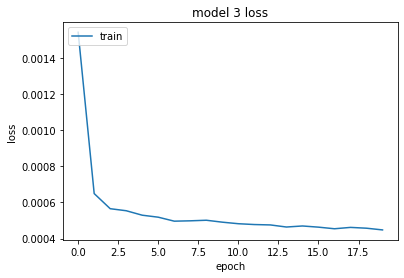

In [47]:
plt.plot(history_3.history['loss'])
#plt.plot(history_3.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# prep inputs to get predictions

dataset_train = df.iloc[:train_size, 1:]
dataset_test = df.iloc[train_size:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

dataset_total.iloc[:, 0:5] = x_sc.fit_transform(dataset_total.iloc[:, 0:5])
dataset_total['Price Ratio'] = y_sc.fit_transform(dataset_total['Price Ratio'].values.reshape(-1,1))

inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,6)

X_test = []
for i in range(window, test_size+window):
    X_test.append(inputs[i-window:i, 0:5])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

# get predictions

predicted_values = model_3.predict(X_test)
predicted_values = y_sc.inverse_transform(predicted_values)

C:\Users\Felix\AppData\Local\Temp\ipykernel_19244\2800303883.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


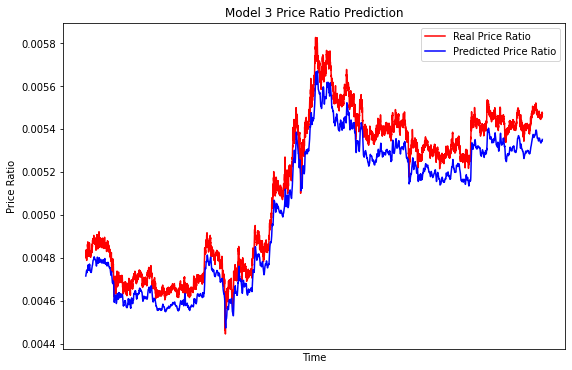

In [49]:
# visualising the results

plt.figure(figsize=(9, 6))
plt.plot(df.iloc[train_size:, 0], dataset_test['Price Ratio'].values, color = 'red', label = 'Real Price Ratio')
plt.plot(df.iloc[train_size:, 0], predicted_values, color = 'blue', label = 'Predicted Price Ratio')
plt.xticks(np.arange(0,test_size,50))
plt.title('Model 3 Price Ratio Prediction')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Price Ratio')
plt.legend()
plt.savefig("ltc_xrp_1min_model3")
plt.show()

In [50]:
# rmse

rmse = mean_squared_error(dataset_test['Price Ratio'].values, predicted_values, squared=False)
print(rmse)

0.00010128319245515256


In [51]:
# std

test_std = np.std(dataset_test['Price Ratio'].values)
print(test_std)

0.0003454332568758069
